<a href="https://colab.research.google.com/github/georgeliu1998/keras_model_tuning/blob/master/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import sklearn
import pickle
from time import time
import importlib # for dynamic class instantiation from a string

from sklearn.model_selection import StratifiedKFold, cross_val_score
#from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
seed = np.random.RandomState(6)

In [4]:
df = pd.read_csv("/content/pima-indians-diabetes.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Get the features and labels as np arrays
X, y = df.values[:, 0:8], df.values[:, 8]
print(X.shape, y.shape)

(768, 8) (768,)


In [6]:
# Get baseline accuracy using XGBoost
clf = xgb.XGBClassifier()
cv = StratifiedKFold(n_splits=3, random_state=seed)

scores = cross_val_score(clf, X, y, cv=cv)

print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(scores.mean(), scores.std()))


Mean Accuracy: 77.61%, Standard Deviation: 3.07%


In [0]:
class SequentialModel:
  """
  The base class for a Neural Networks model
  """
  
  def __init__(self, input_dim, num_layers, num_units, 
               activation, activation_out, 
               loss, initializer, optimizer, learning_rate, 
               metrics, epochs, batch_size, one_hot=False):
    """
    Params:
      input_dim: int, number of features
      num_layers: int, number of layers of the model (excluding the input layer)
      num_units: list, number of units in each layer(excluding the input layer)
      activation: str, activation function used in all layers except output
      activation_out: str, activation function used in output layer
      loss: str, loss functon
      initializer: str, kernel initializer
      optimizer: str, optimizer
      metrics: list of strings, metrics used
      epochs: int, number of epochs to train for
      batch_size: int, number of samples per batch
      one_hot: bool, whether one hot encoding is needed
    """
    self.input_dim = input_dim
    self.num_layers = num_layers
    self.num_units = num_units
    self.activation = activation
    self.activation_out = activation_out
    self.loss = loss
    self.initializer = initializer
    self.optimizer = optimizer
    self.learning_rate = learning_rate
    self.metrics = metrics
    self.epochs = epochs
    self.batch_size = batch_size
    self.one_hot = one_hot
    
    # Initialize the sequential model
    self.model = Sequential()
  
  
    
  def build_model(self):
    """
    Adds layers and compiles the model
    """
    # Ensure num_units tuple's length is the same as num_layers
    if self.num_layers != len(self.num_units):
      # Expand the list by repeating number of nodes except for last layer
      num_nodes, num_nodes_out = self.num_units[0], self.num_units[-1]
      self.num_units = [i for i in range(num_layers-1) for i in [num_nodes]]
      self.num_units.append(num_nodes_out) 
    
    # Loop thru all the layers
    for i in range(self.num_layers):
      # Different layers should have different setups
      if i == 0: # first layer
        self.model.add(Dense(units=self.num_units[i],
                             input_dim=self.input_dim,
                             kernel_initializer=self.initializer,
                             activation=self.activation)) 
      elif i+1 == self.num_layers: # output layer
        self.model.add(Dense(units=self.num_units[i],
                             kernel_initializer=self.initializer,
                             activation=self.activation_out))
      else:
        self.model.add(Dense(units=self.num_units[i],
                            kernel_initializer=self.initializer,
                            activation=self.activation))
    
    # Instantiate the optimizer class
    optimizer_class = getattr(importlib.import_module("keras.optimizers"), 
                             self.optimizer)
    self.optimizer = optimizer_class(lr=self.learning_rate)
    # Compile the model
    self.model.compile(loss=self.loss,
                       optimizer=self.optimizer,
                       metrics=self.metrics)
      
  
  
  def evaluate_model(self, X, y, n_splits=3):
    """
    Evaluates the model using cross-validation.
    
    Params:
      X: np.array, features
      y: np.array, labels
      n_splits: int, number of folds for the cross-validation
    Returns:
      mean_accuracy: float, the average accuracy based on the cross-validation.
    
    """
    score_lst = []
    t1 = time()
    
    print("Starting {}-fold cross-validation...".format(n_splits))
    
    kfold = StratifiedKFold(n_splits=n_splits, 
                            shuffle=True, 
                            random_state=seed)
    
    # Loop through the different folds
    for train_index, test_index in kfold.split(X, y):
      # Do one-hot encoding when needed
      if self.one_hot:
        y_one_hot = to_categorical(y)
      else:
        y_one_hot = y
        
      self.model.fit(X[train_index],
                     y_one_hot[train_index],
                     epochs=self.epochs,
                     batch_size=self.batch_size,
                     verbose=0)
        
      scores = self.model.evaluate(X[test_index],
                                   y_one_hot[test_index], 
                                   verbose=0)
            
      # The second item is accuracy
      score_lst.append(scores[1])

    t2 = time()
    t = t2 - t1
    # Convert time to mintues
    t /= 60

    print("Finished cross-valiation. Took {:.1f} mintues.".format(t))

    # Convert to np.array and calculate mean and sd
    score_lst = np.array(score_lst)
    mean_acc = score_lst.mean()
    sd_acc = score_lst.std()

    print("Mean Accuracy: {:.2%}, Standard Deviation: {:.2%}".format(mean_acc, sd_acc))
    return mean_acc

In [44]:
"""
!pip install kaggle
api_token = {"username":"georgeliu","key":"API_KEY"}
import json
import zipfile
import os
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content
"""

'\n!pip install kaggle\napi_token = {"username":"georgeliu","key":"API_KEY"}\nimport json\nimport zipfile\nimport os\nwith open(\'/content/.kaggle/kaggle.json\', \'w\') as file:\n    json.dump(api_token, file)\n!chmod 600 /content/.kaggle/kaggle.json\n!kaggle config path -p /content\n'

In [17]:
# Get baseline accuracy using the defined Neural Networks class
input_dim = 8
num_layers = 2
num_units = (8, 1) 
activation = 'relu'
activation_out = 'sigmoid'
loss = 'binary_crossentropy'
initializer = 'random_uniform'
optimizer = 'adam'
learning_rate = 0.001
metrics = ['accuracy']
epochs = 10
batch_size = 6
one_hot = False


model = SequentialModel(input_dim=input_dim, 
                        num_layers=num_layers, 
                        num_units=num_units,
                        activation=activation, 
                        activation_out=activation_out, 
                        loss=loss, 
                        initializer=initializer, 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        metrics=metrics, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        one_hot=one_hot)

model.build_model()
model.evaluate_model(X, y)

Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.2 mintues.
Mean Accuracy: 68.88%, Standard Deviation: 1.20%


0.6888040893524298

In [0]:
# Define tuning parameter and corresponding options
width = [4, 8, 16, 32, 64]
depth = [2, 4, 8, 16, 32]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
initializer = ['random_uniform', 'random_normal', 'TruncatedNormal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.001, 0.002, 0.01, 0.1, 1]
optimizer = ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']
epochs = [10, 20, 40, 80, 160]
batch_size = [1, 2, 4, 8, 16]


tuning_options = {'width': width,
                  'depth': depth, 
                  'loss': loss, 
                  'initializer': initializer, 
                  'optimizer': optimizer, 
                  'learning_rate': learning_rate,
                  'epochs': epochs, 
                  'batch_size': batch_size}

In [0]:
def run_test(tuning_options, X, y):
  """
  Tests different hyperparameter's accurcy using the given tuning options
  """
  results = {}

  for parameter, options in tuning_options.items():

    results[parameter] = {}

    input_dim = 8
    num_layers = 2
    num_units = (8, 1) 
    activation = 'relu'
    activation_out = 'sigmoid'
    loss = 'binary_crossentropy'
    initializer = 'random_uniform'
    learning_rate = 0.001
    optimizer = 'adam'
    metrics = ['accuracy']
    epochs = 10
    batch_size = 5
    one_hot = False

    for option in options:

      if parameter == 'width':
        num_units = (option, 1)
      elif parameter == 'depth':
        num_layers = option
      elif parameter == 'loss':
        loss = option
      elif parameter == 'initializer':
        initializer = option
      elif parameter == 'optimizer':
        optimizer = option
      elif parameter == 'learning_rate':
        learning_rate = option
      elif parameter == 'epochs':
        epochs = option
      else:
        batch_size = option

      print("\nEvaluating parameter \"{}\" using value \"{}\"...".format(parameter, option))

      model = SequentialModel(input_dim=input_dim, 
                              num_layers=num_layers, 
                              num_units=num_units,
                              activation=activation, 
                              activation_out=activation_out, 
                              loss=loss, 
                              initializer=initializer, 
                              optimizer=optimizer, 
                              learning_rate=learning_rate, 
                              metrics=metrics, 
                              epochs=epochs, 
                              batch_size=batch_size, 
                              one_hot=one_hot)
      
      try:
        model.build_model()
        result = model.evaluate_model(X, y)  
        results[parameter][option] = result
      except Exception as e: 
        results[parameter][option] = 'NaN'
        print('Error: {}, skipping...'.format(e))
        pass

  return results

In [20]:
results = run_test(tuning_options, X, y)
# Save the dict    
with open('cross_validation_results.pkl', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)


Evaluating parameter "width" using value "4"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.2 mintues.
Mean Accuracy: 69.01%, Standard Deviation: 1.01%

Evaluating parameter "width" using value "8"...
Starting 3-fold cross-validation...


KeyboardInterrupt: ignored

In [0]:
with open('cross_validation_results.pkl', 'rb') as f:
    tuning_results = pickle.load(f)

In [0]:
def wrangle(tuning_results):
    """
    Params:
        tuning_results: dict, the dict loaded from pickled hyperparameter tuning results
    
    Returns:
        df_long: pandas df, the wrangled long format dataframe
    """
    # Save as df
    df = pd.DataFrame(tuning_results)
    # Get the col names as value vars for melt func
    value_vars = df.columns.tolist()
    # Reset index and rename the index col 
    df = df.reset_index().rename(columns={'index': 'option'})
    # Transform from wide to long format for easy plotting
    df_long = pd.melt(df, id_vars='option', value_vars=value_vars)
    df_long = df_long.rename(columns={'variable': 'parameter'})
    # Exclude the zero and null values
    df_long = df_long[~df_long['value'].isnull()]
    df_long = df_long.query("value!=0 & value!='NaN'")
    
    return df_long

df_long = wrangle(tuning_results)

In [0]:
def transform_df(df_long):
  """
  Transforms the long form df into a plottable df
  """

  # Calculate the range and sd of each parameter group and convert to a df
  ranges = df_long.groupby('parameter').apply(lambda grp: grp.value.max() - grp.value.min())
  sd = df_long.groupby('parameter').apply(lambda grp: grp.value.std())
  spread = pd.concat([ranges, sd], axis=1).rename(columns={0: 'ranges', 1: 'sd'})

  # Join back the df
  df_spread = pd.merge(df_long, spread, how='left', left_on='parameter', right_index=True)

  # Reorder columns
  df_spread = df_spread[['parameter', 'option', 'value', 'ranges', 'sd']]

  # Remove the row with zero value
  df_spread = df_spread.query('ranges!=0')

  # Sort the dataframe and use the resulting index to slice
  # This ensures the plot will be ordered accordingly
  idx = df_spread.sort_values(by=['ranges', 'option'], ascending=False).index
  df_plot = df_spread.loc[idx, :]
  df_plot
  
  return df_plot

df_plot = transform_df(df_long)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


Text(0,0.5,'Values')

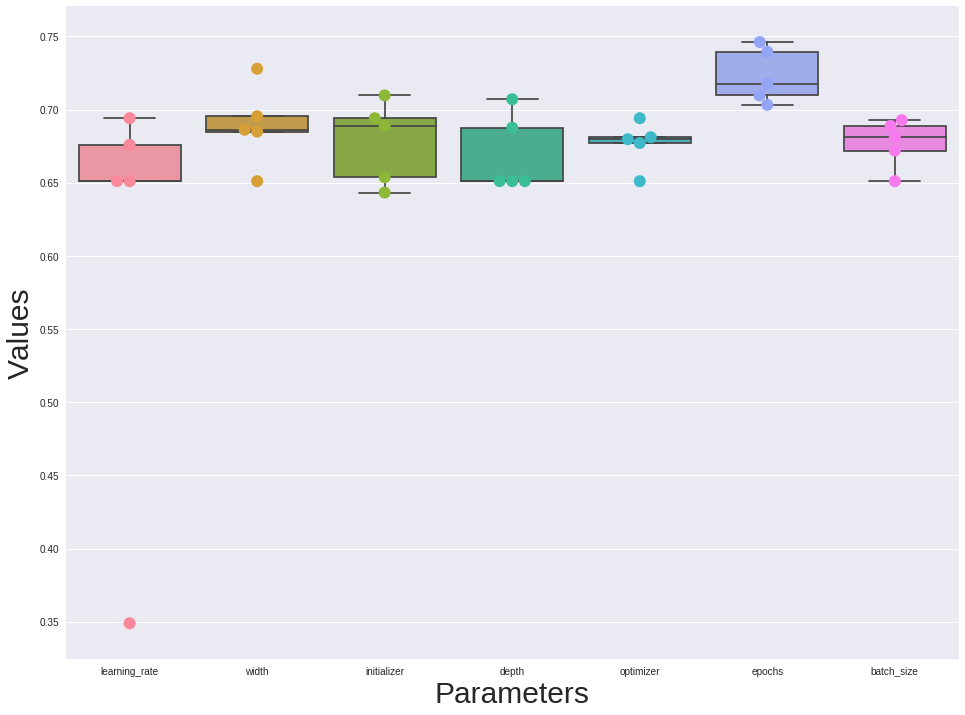

In [25]:
fig, ax = plt.subplots(figsize=(16, 12))
df_plot['value'] = df_plot['value'].astype(float)
sns.boxplot(x='parameter', y='value', data=df_plot, ax=ax)
sns.swarmplot(x='parameter', y='value', data=df_plot, size=12, ax=ax)
ax.set_xlabel('Parameters',size=30)
ax.set_ylabel('Values',size=30)

In [32]:
#import math
df_plot.query('parameter=="learning_rate"')

,parameter,option,value,ranges,sd
116,learning_rate,1,0.348957,0.345127,0.143832
135,learning_rate,0.1,0.651043,0.345127,0.143832
134,learning_rate,0.01,0.651043,0.345127,0.143832
133,learning_rate,0.002,0.675854,0.345127,0.143832
132,learning_rate,0.001,0.694083,0.345127,0.143832


In [65]:
# Define tuning parameter and corresponding options
learning_rate = [0.0008, 0.0009, 0.00095, 0.001, 0.0015, 0.0018]

tuning_options = {'learning_rate': learning_rate}

result = run_test(tuning_options, X, y)


Evaluating parameter "learning_rate" using value "0.0008"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 70.84%, Standard Deviation: 1.94%

Evaluating parameter "learning_rate" using value "0.0009"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 67.98%, Standard Deviation: 2.67%

Evaluating parameter "learning_rate" using value "0.00095"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 70.19%, Standard Deviation: 2.03%

Evaluating parameter "learning_rate" using value "0.001"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 68.49%, Standard Deviation: 0.88%

Evaluating parameter "learning_rate" using value "0.0015"...
Starting 3-fold cross-validation...
Finished cross-valiation. Took 0.3 mintues.
Mean Accuracy: 69.53%, Standard Deviation: 1.01%

Evaluating parameter "learning_rate" using v

In [0]:
def visualize(result, param_tuned):
  """
  Visualizes the hyperparameter tuning result
  
  Params:
    result - dict, result dict returned by the run_test() func
    param_tuned - string, one of these:
      ['width', 'depth', 'loss', 'initializer', 'optimizer', 'learning_rate', 'epochs', 'batch_size']
  returns:
    None
  """

  d = result['learning_rate']

  xs, ys = np.array(list(d.keys())), np.array(list(d.values()))

  fig, ax = plt.subplots(figsize=(12, 8))
  plt.plot(xs, ys)  
  ax.set_xlim(xs.min()*0.9, xs.max()*1.1)
  plt.show()

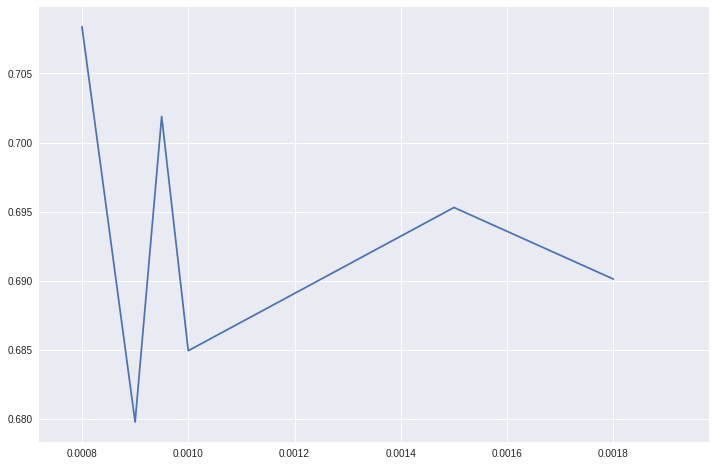

In [67]:
visualize(result, 'learning_rate')

In [0]:
# Define tuning parameter and corresponding options
width = [4, 8, 16, 32, 64]
depth = [2, 4, 8, 16, 32]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy']
initializer = ['random_uniform', 'random_normal', 'TruncatedNormal', 'glorot_normal', 'glorot_uniform']
learning_rate = [0.001, 0.002, 0.01, 0.1, 1]
optimizer = ['adam', 'adamax', 'adagrad', 'sgd', 'rmsprop']
epochs = [10, 20, 40, 80, 160]
batch_size = [1, 2, 4, 8, 16]


tuning_options = {'width': width,
                  'depth': depth, 
                  'loss': loss, 
                  'initializer': initializer, 
                  'optimizer': optimizer, 
                  'learning_rate': learning_rate,
                  'epochs': epochs, 
                  'batch_size': batch_size}

1. persisting file
2. download pima from kaggle
3. random search
4.
